In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time
from gprofiler import GProfiler
import gseapy as gp

# scDRS tools
import scdrs

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Set file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data'
DF_HOM = pd.read_csv(DATA_PATH+'/gene_annotation/mouse_human_homologs.txt', sep='\t')
DIC_MAP_H2M = {x:y for x,y in zip(DF_HOM['HUMAN_GENE_SYM'], DF_HOM['MOUSE_GENE_SYM'])}
DIC_MAP_M2H = {x:y for x,y in zip(DF_HOM['MOUSE_GENE_SYM'], DF_HOM['HUMAN_GENE_SYM'])}
DF_GS = pd.read_csv(DATA_PATH+'/gs_file/magma_10kb_top1000_zscore.74_traits.rv1.gs', sep='\t', index_col=0)
DF_TRAIT_INFO = pd.read_csv(DATA_PATH+'/supp_table.rv1/trait_info.tsv', sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/results/fig_brain.rv1'

# Data set info
DS_LIST = ['facs']
DIC_INFO = {}
DIC_INFO['facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}

# Set score files
DIC_SCORE_PATH = {
    'facs': DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_top1000_zscore',
}

# Set trait list
DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST['facs'] = ['PASS_Schizophrenia_Pardinas2018',
                          'PASS_BIP_Mullins2021', 
                          'PASS_MDD_Howard2019', 
                          'UKB_460K.mental_NEUROTICISM',
                          'UKB_460K.cov_EDU_COLLEGE',
                          'UKB_460K.body_BMIz',
                          'UKB_460K.cov_SMOKING_STATUS' ]

### Load data 

In [3]:
# Load single-cell data 
dic_data_raw = {}
dic_data_raw['facs'] = scdrs.data_loader.load_tms_ct(DATA_PATH, data_name='facs')

dic_data_proc = {}
dic_data_proc['facs'] = read_h5ad(
    DATA_PATH+'/tabula_muris_senis/tabula-muris-senis-facs-processed-official-annotations-Brain_Non-Myeloid.h5ad'
)

Trying to set attribute `.obs` of view, copying.
/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [4]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        file_path = join(DIC_SCORE_PATH[score], '%s.score.gz'%trait)
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)        

# Cell list to analyze
dic_cell_list = {}
for score in DIC_SCORE_PATH:
    ds = score.replace('.hm','')
    dic_cell_list[score] = list(set(dic_data_proc[ds].obs_names) & set(dic_score[score].index))

In [6]:
# # Load control score 
# dic_ctrl_score = {}
# for score in DIC_SCORE_PATH:
# # for score in ['aizarani', 'halpern', 'richter']:
#     ds = score.split('.')[0]
#     dic_ctrl_score[score] = {}
#     for trait in DIC_TRAIT_LIST[score]:
#         file_path = join(DIC_SCORE_PATH[score], '%s.full_score.gz'%trait)
#         if os.path.exists(file_path):
#             print('# Loading %s %s'%(score, trait))
#             temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
#             temp_df = temp_df.loc[set(dic_data_proc[ds].obs_names) & set(temp_df.index)]
#             dic_ctrl_score[score][trait] = temp_df.copy()
#         else:
#             print('# missing: %s'%file_path)
#             continue
#         dic_ctrl_score[score][trait] = dic_ctrl_score[score][trait].loc[dic_cell_list[score]].copy()

### UMAP for all hepatocytes

n_cell=7249


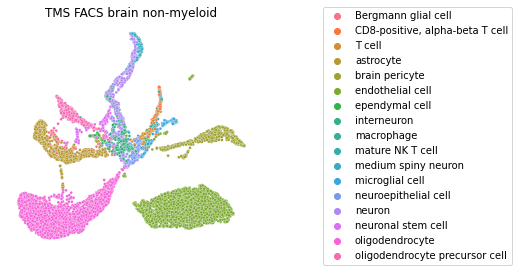

In [5]:
# Figure 
df_plot = pd.DataFrame(index=dic_data_proc['facs'].obs_names,
                       data={'UMAP1':dic_data_proc['facs'].obsm['X_umap'][:,0],
                             'UMAP2':dic_data_proc['facs'].obsm['X_umap'][:,1]})
df_plot = df_plot.join(dic_data_proc['facs'].obs['cell_ontology_class'])
print('n_cell=%d'%df_plot.shape[0])

plt.figure(figsize=[8,4])
ax = plt.subplot(1,1,1)
ax.axis('off')
g = sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='cell_ontology_class', s=8)
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('TMS FACS brain non-myeloid')
plt.tight_layout()
# plt.savefig(FIG_PATH+'/hep_tms_annot_umap.svg')
# plt.savefig(FIG_PATH+'/hep_tms_annot_umap.png')
plt.show()

### Subpolulation of associated cells 

# SCZ associated cells=903/7249


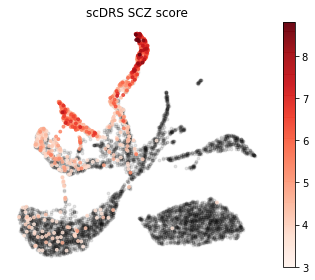

# BP associated cells=585/7249


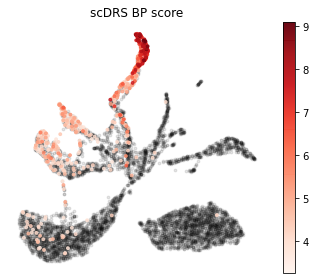

# MDD associated cells=752/7249


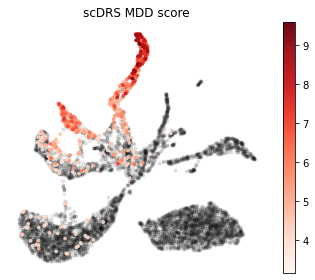

# NRT associated cells=1193/7249


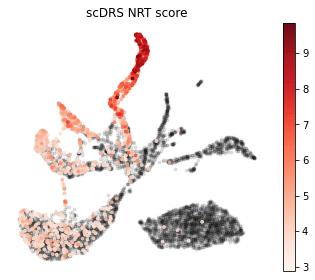

# ECOL associated cells=1193/7249


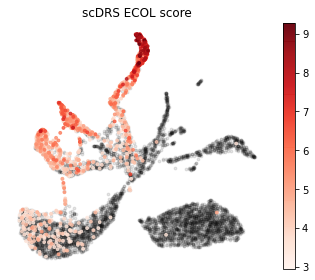

# BMI associated cells=985/7249


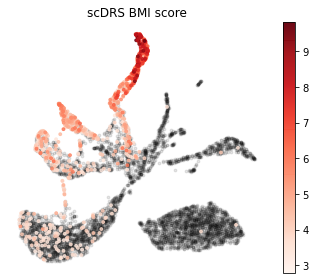

# Smoking associated cells=603/7249


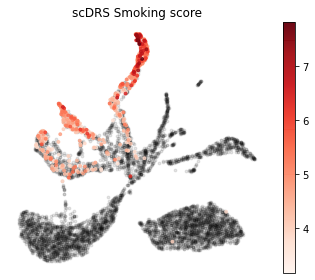

In [8]:
ds = 'facs'
for trait in DIC_TRAIT_LIST['facs']:
    df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                           data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                                 'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1], 
                                 'leiden_anno':dic_data_proc[ds].obs['leiden']})
    df_plot = df_plot.loc[dic_cell_list[ds]]
    df_plot = df_plot.join(dic_score[ds][['%s.fdr'%trait, '%s.nlog10_pval'%trait, '%s.norm_score'%trait]])
    df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

    ind_select = df_plot['%s.fdr'%trait]<0.1
    print('# %s associated cells=%d/%d'%(DF_TRAIT_INFO.loc[trait, 'Code'], ind_select.sum(), ind_select.shape[0]))

    plt.figure(figsize=[4.8,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')
    plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                c='k', s=8, alpha=0.1)
    if ind_select.sum()>0:
        vmax = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.99) + 0.5
        vmin = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.01) - 0.5
        plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
                    c=df_plot.loc[ind_select, '%s.norm_score'%trait],
                    cmap='Reds', s=8, vmax=vmax, vmin=vmin, alpha=0.8)
    plt.colorbar()
    plt.title('scDRS %s score'%DF_TRAIT_INFO.loc[trait, 'Code'])

    plt.tight_layout()
#     plt.savefig(FIG_PATH+'/sctrs_assoc.%s.%s.svg'%(ds, trait))
    plt.show()

In [18]:
celltype_list

['Bergmann glial cell',
 'CD8-positive, alpha-beta T cell',
 'T cell',
 'astrocyte',
 'brain pericyte',
 'endothelial cell',
 'ependymal cell',
 'interneuron',
 'macrophage',
 'mature NK T cell',
 'medium spiny neuron',
 'microglial cell',
 'neuroepithelial cell',
 'neuron',
 'neuronal stem cell',
 'oligodendrocyte',
 'oligodendrocyte precursor cell']

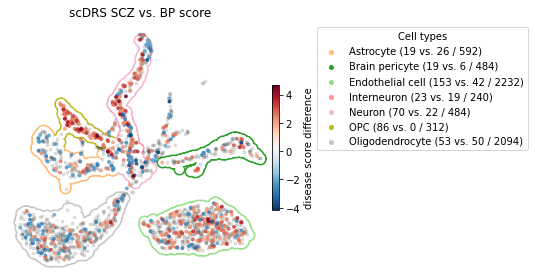

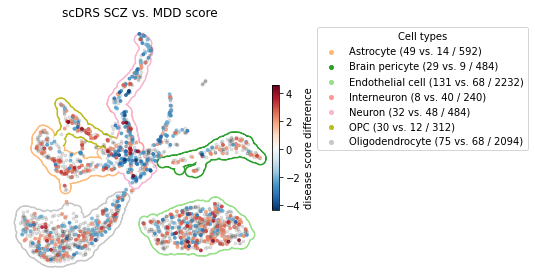

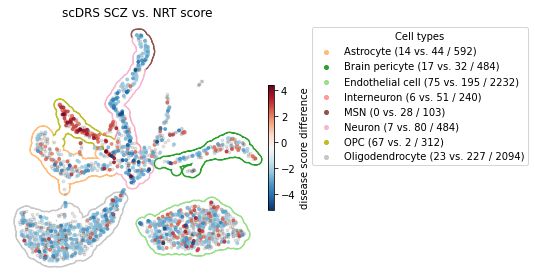

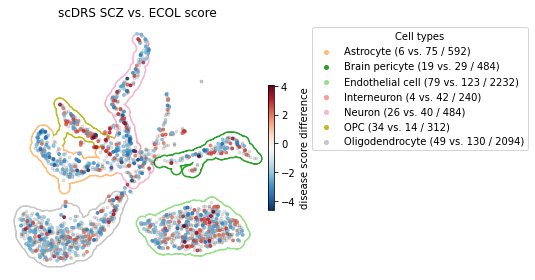

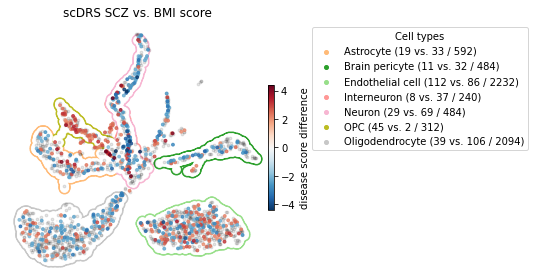

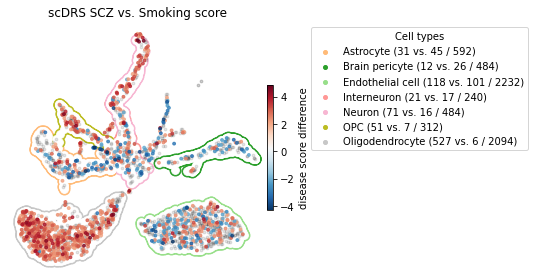

In [26]:
# UMAP for score differences of IBD vs. other pairs
cmap = matplotlib.cm.get_cmap('tab20')
celltype_list = sorted(dic_data_proc['facs'].obs['cell_ontology_class'].unique())
dic_ct_name = {
    'Bergmann glial cell' : 'Bergmann glial',
    'CD8-positive, alpha-beta T cell' : 'CD8+ $\alpha$-$\beta$ T',
    'oligodendrocyte precursor cell' : 'OPC',
    'medium spiny neuron' : 'MSN',
}
dic_cmap = {'%s.sig'%x:i for i,x in enumerate(celltype_list)}
dic_config = {
    '%s.sig'%x: ['%s @a'%dic_ct_name[x]] if x in dic_ct_name else ['%s @a'%x.capitalize()]
    for x in celltype_list}

trait1 = 'PASS_Schizophrenia_Pardinas2018'

for trait2 in DIC_TRAIT_LIST['facs']:
    if trait2 in ['PASS_Schizophrenia_Pardinas2018']:
        continue
        
    # Get df_plot     
    df_plot = pd.DataFrame(index = dic_data_proc['facs'].obs_names, 
                           data={'UMAP1' : dic_data_proc['facs'].obsm['X_umap'][:,0],
                                 'UMAP2' : dic_data_proc['facs'].obsm['X_umap'][:,1]})
    df_plot = df_plot.join(dic_data_proc['facs'].obs[['cell_ontology_class', 'cell']])
    df_plot['leiden'] = df_plot['cell_ontology_class'].copy()
    df_plot = df_plot.join(dic_score['facs'][['%s.norm_score'%trait1, '%s.norm_score'%trait2]])
    df_plot['norm_score_dif'] = df_plot['%s.norm_score'%trait1] - df_plot['%s.norm_score'%trait2]
    df_plot['abs_norm_score_dif'] = np.absolute(df_plot['norm_score_dif'])
    df_plot.sort_values('abs_norm_score_dif', ascending=True, inplace=True)

    df_plot['leiden_sig1'] = ['%s.sig'%x if y>2 else 'nonsig'
                              for x,y in zip(df_plot['leiden'], df_plot['norm_score_dif'])]
    df_plot['leiden_sig2'] = ['%s.sig'%x if y<-2 else 'nonsig'
                              for x,y in zip(df_plot['leiden'], df_plot['norm_score_dif'])]
    df_plot['leiden_sig'] = ['%s.sig'%x if y>2 else 'nonsig'
                              for x,y in zip(df_plot['leiden'], df_plot['abs_norm_score_dif'])]
    
    # Supp. fig
    temp_df = df_plot.groupby('leiden_sig').agg({'cell' : len})
    group_list = list(temp_df.index[temp_df['cell']>=25])
    group_list = [x for x in group_list if x!='nonsig']
   
    # Figure 
    plt.figure(figsize=[7.5,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')

    # Cluster boundry 
    x_range = df_plot['UMAP1'].max()-df_plot['UMAP1'].min()
    y_range = df_plot['UMAP2'].max()-df_plot['UMAP2'].min()
    for cluster in group_list:
        ind_select = df_plot['leiden']==cluster.split('.')[0]
        assoc_str = '(%s vs. %s / %s)'%(
            (ind_select&(df_plot['leiden_sig1']!='nonsig')).sum(), 
            (ind_select&(df_plot['leiden_sig2']!='nonsig')).sum(),
            ind_select.sum()
        )
        temp_df = df_plot.loc[ind_select, ['UMAP1', 'UMAP2']].copy()
        xmin = np.quantile(temp_df['UMAP1'], 0.05)-0.05*x_range,
        xmax = np.quantile(temp_df['UMAP1'], 0.95)+0.05*x_range
        ymin = np.quantile(temp_df['UMAP2'], 0.05)-0.05*y_range,
        ymax = np.quantile(temp_df['UMAP2'], 0.95)+0.05*y_range
        ind_select = (temp_df['UMAP1']>xmin) & (temp_df['UMAP1']<xmax) & \
                        (temp_df['UMAP2']>ymin) & (temp_df['UMAP2']<ymax)
        plt.scatter(temp_df.loc[ind_select, 'UMAP1'][:2], temp_df.loc[ind_select, 'UMAP2'][:2],
                    s=16, color=cmap(dic_cmap[cluster]),
                    label=dic_config[cluster][0].replace('@a',assoc_str), zorder=0)
        plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                    s=120, color=cmap(dic_cmap[cluster]), zorder=1)
        plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                    s=60, color='w', zorder=2)
    
    # Grey for non-sig cells 
    np.random.seed(0)
    ind_select_sig = (df_plot['leiden_sig']!='nonsig')
    cell_list_nonsig = np.random.choice(
        df_plot.index[~ind_select_sig], size=int((~ind_select_sig).sum()*0.2), replace=False)
    plt.scatter(df_plot.loc[cell_list_nonsig, 'UMAP1'], df_plot.loc[cell_list_nonsig, 'UMAP2'],
                c='k', s=8, alpha=0.1, zorder=5)
    
    # Red for sig cells 
    vmax = np.quantile(df_plot.loc[ind_select_sig, 'norm_score_dif'], 0.99) + 0.5
    vmin = np.quantile(df_plot.loc[ind_select_sig, 'norm_score_dif'], 0.01) - 0.5
    plt.scatter(df_plot.loc[ind_select_sig, 'UMAP1'], df_plot.loc[ind_select_sig, 'UMAP2'], 
                c=df_plot.loc[ind_select_sig, 'norm_score_dif'],
                cmap='RdBu_r', s=8, vmax=vmax, vmin=vmin, alpha=0.8, zorder=10)
    plt.colorbar(shrink=0.5, pad=0, label='disease score difference')
    plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left',
               title='Cell types')
    plt.title('scDRS %s vs. %s score'%(DF_TRAIT_INFO.loc[trait1, 'Code'], DF_TRAIT_INFO.loc[trait2, 'Code']))

    plt.tight_layout()
    plt.savefig(FIG_PATH+'/sctrs_assoc_dif.%s.%s.%s.svg'%(score, trait1, trait2))
    plt.savefig(FIG_PATH+'/sctrs_assoc_dif.%s.%s.%s.png'%(score, trait1, trait2))
    plt.show()

In [16]:
dic_data_proc['facs'].obs['leiden'] = dic_data_proc['facs'].obs['cell_ontology_class']

In [36]:
dic_cmap = {'%s.sig'%x:i for i,x in enumerate(set(dic_data_proc['facs'].obs['cell_ontology_class']))}
dic_config = {'%s.sig'%x: ['%s @a'%x] for i,x in enumerate(set(dic_data_proc['facs'].obs['cell_ontology_class']))}

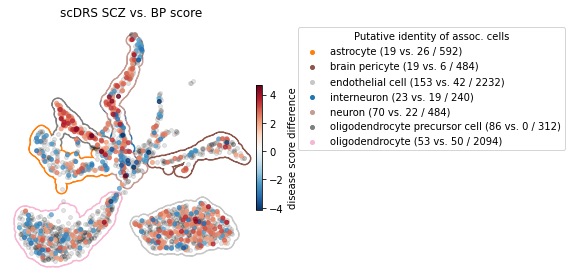

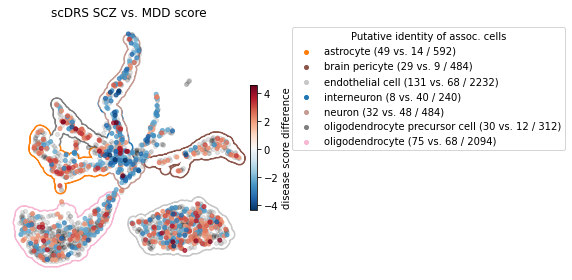

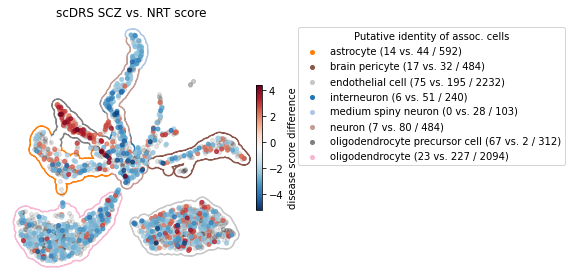

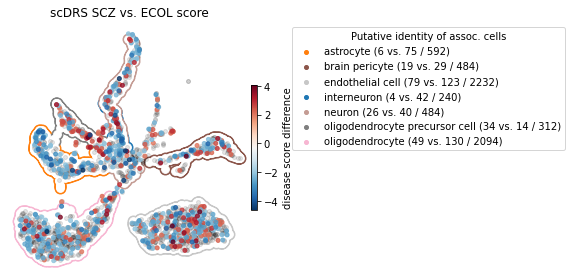

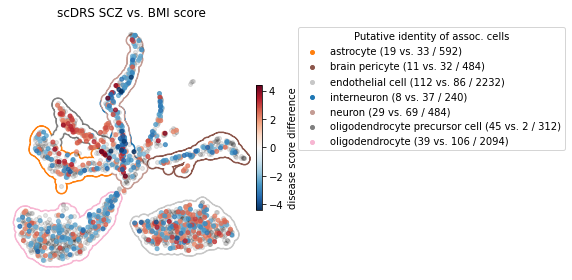

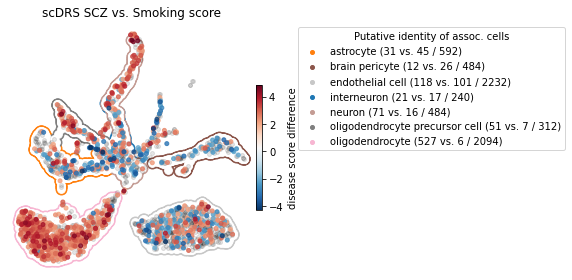

In [38]:
# UMAP for score differences of IBD vs. other pairs
def num2str(x):
    return '%d'%x if x>=25 else '-'
cmap = matplotlib.cm.get_cmap('tab20')

# dic_config = {
#     '0.sig' : ['1 @a: high ploidy, pericentral'], 
#     '1.sig' : ['2 @a: high ploidy, periportal'],
#     '2.sig' : ['3 @a: mid ploidy'],
#     '3.sig' : ['4 @a: low ploidy'],
#     '4.sig' : ['5 @a: low ploidy'],
#     '5.sig' : ['6 @a: low ploidy'],
# }

trait1 = 'PASS_Schizophrenia_Pardinas2018'

for trait2 in DIC_TRAIT_LIST['facs']:
    if trait2 in ['PASS_Schizophrenia_Pardinas2018']:
        continue
        
    # Get df_plot     
    df_plot = pd.DataFrame(index = dic_data_proc['facs'].obs_names, 
                           data={'UMAP1' : dic_data_proc['facs'].obsm['X_umap'][:,0],
                                 'UMAP2' : dic_data_proc['facs'].obsm['X_umap'][:,1]})
    df_plot = df_plot.join(dic_data_proc['facs'].obs[['leiden', 'cell']])
    df_plot = df_plot.join(dic_score['facs'][['%s.norm_score'%trait1, '%s.norm_score'%trait2]])
    df_plot['norm_score_dif'] = df_plot['%s.norm_score'%trait1] - df_plot['%s.norm_score'%trait2]
    df_plot['abs_norm_score_dif'] = np.absolute(df_plot['norm_score_dif'])
    df_plot.sort_values('abs_norm_score_dif', ascending=True, inplace=True)

    df_plot['leiden_sig1'] = ['%s.sig'%x if y>2 else 'nonsig'
                              for x,y in zip(df_plot['leiden'], df_plot['norm_score_dif'])]
    df_plot['leiden_sig2'] = ['%s.sig'%x if y<-2 else 'nonsig'
                              for x,y in zip(df_plot['leiden'], df_plot['norm_score_dif'])]
    df_plot['leiden_sig'] = ['%s.sig'%x if y>2 else 'nonsig'
                              for x,y in zip(df_plot['leiden'], df_plot['abs_norm_score_dif'])]
    
    # Supp. fig
    temp_df = df_plot.groupby('leiden_sig').agg({'cell' : len})
    group_list = list(temp_df.index[temp_df['cell']>=25])
    
#     group_list = [int(x.replace('.sig','')) for x in group_list if x!='nonsig']
#     group_list = ['%d.sig'%x for x in sorted(group_list)]
    group_list = [x for x in group_list if x!='nonsig']
   
    # Figure 
    plt.figure(figsize=[8,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')

    # Cluster boundry 
    x_range = df_plot['UMAP1'].max()-df_plot['UMAP1'].min()
    y_range = df_plot['UMAP2'].max()-df_plot['UMAP2'].min()
    for cluster in group_list:
        ind_select = df_plot['leiden']==cluster.split('.')[0]
        assoc_str = '(%s vs. %s / %s)'%(
            (ind_select&(df_plot['leiden_sig1']!='nonsig')).sum(), 
            (ind_select&(df_plot['leiden_sig2']!='nonsig')).sum(),
            ind_select.sum()
        )
        temp_df = df_plot.loc[ind_select, ['UMAP1', 'UMAP2']].copy()
        xmin = np.quantile(temp_df['UMAP1'], 0.05)-0.05*x_range,
        xmax = np.quantile(temp_df['UMAP1'], 0.95)+0.05*x_range
        ymin = np.quantile(temp_df['UMAP2'], 0.05)-0.05*y_range,
        ymax = np.quantile(temp_df['UMAP2'], 0.95)+0.05*y_range
        ind_select = (temp_df['UMAP1']>xmin) & (temp_df['UMAP1']<xmax) & \
                        (temp_df['UMAP2']>ymin) & (temp_df['UMAP2']<ymax)
        plt.scatter(temp_df.loc[ind_select, 'UMAP1'][:2], temp_df.loc[ind_select, 'UMAP2'][:2],
                    s=16, color=cmap(dic_cmap[cluster]),
                    label=dic_config[cluster][0].replace('@a',assoc_str), zorder=0)
        plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                    s=120, color=cmap(dic_cmap[cluster]), zorder=1)
        plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                    s=60, color='w', zorder=2)
    
    # Grey for non-sig cells 
    np.random.seed(0)
    ind_select_sig = (df_plot['leiden_sig']!='nonsig')
    cell_list_nonsig = np.random.choice(
        df_plot.index[~ind_select_sig], size=int((~ind_select_sig).sum()*0.2), replace=False)
    plt.scatter(df_plot.loc[cell_list_nonsig, 'UMAP1'], df_plot.loc[cell_list_nonsig, 'UMAP2'],
                c='k', s=16, alpha=0.1, zorder=5)
    
    # Red for sig cells 
    vmax = np.quantile(df_plot.loc[ind_select_sig, 'norm_score_dif'], 0.99) + 0.5
    vmin = np.quantile(df_plot.loc[ind_select_sig, 'norm_score_dif'], 0.01) - 0.5
    plt.scatter(df_plot.loc[ind_select_sig, 'UMAP1'], df_plot.loc[ind_select_sig, 'UMAP2'], 
                c=df_plot.loc[ind_select_sig, 'norm_score_dif'],
                cmap='RdBu_r', s=16, vmax=vmax, vmin=vmin, alpha=0.8, zorder=10)
    plt.colorbar(shrink=0.5, pad=0, label='disease score difference')
    plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left',
               title='Putative identity of assoc. cells')
    plt.title('scDRS %s vs. %s score'%(DF_TRAIT_INFO.loc[trait1, 'Code'], DF_TRAIT_INFO.loc[trait2, 'Code']))

    plt.tight_layout()
    plt.savefig(FIG_PATH+'/sctrs_assoc_dif.%s.%s.%s.svg'%(score, trait1, trait2))
    plt.savefig(FIG_PATH+'/sctrs_assoc_dif.%s.%s.%s.png'%(score, trait1, trait2))
    plt.show()

In [14]:
# # UMAP for score differences of IBD vs. other pairs
# def num2str(x):
#     return '%d'%x if x>=25 else '-'
# cmap = matplotlib.cm.get_cmap('tab20')

# dic_config = {
#     '0.sig' : ['1 @a: high ploidy, pericentral'], 
#     '1.sig' : ['2 @a: high ploidy, periportal'],
#     '2.sig' : ['3 @a: mid ploidy'],
#     '3.sig' : ['4 @a: low ploidy'],
#     '4.sig' : ['5 @a: low ploidy'],
#     '5.sig' : ['6 @a: low ploidy'],
# }

# trait1 = 'UKB_460K.biochemistry_Triglycerides'

# for trait2 in DIC_TRAIT_LIST['facs']:
#     if trait2 in ['UKB_460K.biochemistry_Triglycerides', 'UKB_460K.body_HEIGHTz']:
#         continue
#     # Get df_plot     
#     df_plot = pd.DataFrame(index = dic_data_proc['facs'].obs_names, 
#                            data={'UMAP1' : dic_data_proc['facs'].obsm['X_umap'][:,0],
#                                  'UMAP2' : dic_data_proc['facs'].obsm['X_umap'][:,1]})
#     df_plot = df_plot.join(dic_data_proc['facs'].obs[['leiden', 'cell']])
#     df_plot = df_plot.join(dic_score['facs'][['%s.norm_score'%trait1, '%s.norm_score'%trait2]])
#     df_plot['norm_score_dif'] = df_plot['%s.norm_score'%trait1] - df_plot['%s.norm_score'%trait2]
#     df_plot['abs_norm_score_dif'] = np.absolute(df_plot['norm_score_dif'])
#     df_plot.sort_values('abs_norm_score_dif', ascending=True, inplace=True)

#     df_plot['leiden_sig1'] = ['%s.sig'%x if y>2 else 'nonsig'
#                               for x,y in zip(df_plot['leiden'], df_plot['norm_score_dif'])]
#     df_plot['leiden_sig2'] = ['%s.sig'%x if y<-2 else 'nonsig'
#                               for x,y in zip(df_plot['leiden'], df_plot['norm_score_dif'])]
#     df_plot['leiden_sig'] = ['%s.sig'%x if y>2 else 'nonsig'
#                               for x,y in zip(df_plot['leiden'], df_plot['abs_norm_score_dif'])]
    
#     # Supp. fig
#     temp_df = df_plot.groupby('leiden_sig').agg({'cell' : len})
#     group_list = list(temp_df.index[temp_df['cell']>=10])
# #     dic_config = { x : ['%s @a'%x.split('.')[0]] for x in group_list}
# #         title_ = 'Clusters'
# #         figsize_ = [6.5,4]
    
#     group_list = [int(x.replace('.sig','')) for x in group_list if x!='nonsig']
#     group_list = ['%d.sig'%x for x in sorted(group_list)]
   
#     # Figure 
#     plt.figure(figsize=[8,4])
#     ax = plt.subplot(1,1,1)
#     ax.axis('off')

#     # Cluster boundry 
#     x_range = df_plot['UMAP1'].max()-df_plot['UMAP1'].min()
#     y_range = df_plot['UMAP2'].max()-df_plot['UMAP2'].min()
#     for cluster in group_list:
#         ind_select = df_plot['leiden']==cluster.split('.')[0]
#         assoc_str = '(%s vs. %s / %s)'%(
#             (ind_select&(df_plot['leiden_sig1']!='nonsig')).sum(), 
#             (ind_select&(df_plot['leiden_sig2']!='nonsig')).sum(),
#             ind_select.sum()
#         )
#         temp_df = df_plot.loc[ind_select, ['UMAP1', 'UMAP2']].copy()
#         xmin = np.quantile(temp_df['UMAP1'], 0.05)-0.05*x_range,
#         xmax = np.quantile(temp_df['UMAP1'], 0.95)+0.05*x_range
#         ymin = np.quantile(temp_df['UMAP2'], 0.05)-0.05*y_range,
#         ymax = np.quantile(temp_df['UMAP2'], 0.95)+0.05*y_range
#         ind_select = (temp_df['UMAP1']>xmin) & (temp_df['UMAP1']<xmax) & \
#                         (temp_df['UMAP2']>ymin) & (temp_df['UMAP2']<ymax)
#         plt.scatter(temp_df.loc[ind_select, 'UMAP1'][:2], temp_df.loc[ind_select, 'UMAP2'][:2],
#                     s=16, color=cmap(int(cluster.split('.')[0])-1),
#                     label=dic_config[cluster][0].replace('@a',assoc_str), zorder=0)
#         plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
#                     s=120, color=cmap(int(cluster.split('.')[0])-1), zorder=1)
#         plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
#                     s=60, color='w', zorder=2)
    
#     # Grey for non-sig cells 
#     np.random.seed(0)
#     ind_select_sig = (df_plot['leiden_sig']!='nonsig')
#     cell_list_nonsig = np.random.choice(
#         df_plot.index[~ind_select_sig], size=int((~ind_select_sig).sum()*0.2), replace=False)
#     plt.scatter(df_plot.loc[cell_list_nonsig, 'UMAP1'], df_plot.loc[cell_list_nonsig, 'UMAP2'],
#                 c='k', s=16, alpha=0.1, zorder=5)
    
#     # Red for sig cells 
#     vmax = np.quantile(df_plot.loc[ind_select_sig, 'norm_score_dif'], 0.99) + 0.5
#     vmin = np.quantile(df_plot.loc[ind_select_sig, 'norm_score_dif'], 0.01) - 0.5
#     plt.scatter(df_plot.loc[ind_select_sig, 'UMAP1'], df_plot.loc[ind_select_sig, 'UMAP2'], 
#                 c=df_plot.loc[ind_select_sig, 'norm_score_dif'],
#                 cmap='RdBu_r', s=16, vmax=vmax, vmin=vmin, alpha=0.8, zorder=10)
#     plt.colorbar(shrink=0.5, pad=0, label='disease score difference')
#     plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left',
#                title='Putative identity of assoc. cells')
#     plt.title('scDRS %s vs. %s score'%(DF_TRAIT_INFO.loc[trait1, 'Code'], DF_TRAIT_INFO.loc[trait2, 'Code']))

#     plt.tight_layout()
#     plt.savefig(FIG_PATH+'/sctrs_assoc_dif.%s.%s.%s.svg'%(score, trait1, trait2))
#     plt.savefig(FIG_PATH+'/sctrs_assoc_dif.%s.%s.%s.png'%(score, trait1, trait2))
#     plt.show()

KeyError: "['UKB_460K.biochemistry_Triglycerides.norm_score'] not in index"